<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Dataset-Information" data-toc-modified-id="Dataset-Information-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dataset Information</a></span></li><li><span><a href="#Clean-Features" data-toc-modified-id="Clean-Features-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Clean Features</a></span><ul class="toc-item"><li><span><a href="#Nans" data-toc-modified-id="Nans-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Nans</a></span></li><li><span><a href="#Dummy-Variables" data-toc-modified-id="Dummy-Variables-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Dummy Variables</a></span></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Outliers</a></span></li></ul></li><li><span><a href="#Feature-Visualizations" data-toc-modified-id="Feature-Visualizations-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Feature Visualizations</a></span></li></ul></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Determine-Best-Model" data-toc-modified-id="Determine-Best-Model-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Determine Best Model</a></span></li><li><span><a href="#Evaluating-Best-Model" data-toc-modified-id="Evaluating-Best-Model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Evaluating Best Model</a></span></li></ul></li><li><span><a href="#External-Feature:-Interest-Rate" data-toc-modified-id="External-Feature:-Interest-Rate-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>External Feature: Interest Rate</a></span></li></ul></div>

# Introduction

- Load the houseprices data from Thinkful's database.
- Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
- Now, split your data into train and test sets where 20% of the data resides in the test set.
- Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
- Evaluate your best model on the test set.
- So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.


# Imports

In [32]:
from sqlalchemy import create_engine

from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, RidgeCV, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV


%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

In [33]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
housing_df = pd.read_sql_query('select * from houseprices', con=engine)

original_df = housing_df.copy()
engine.dispose()

# EDA

## Dataset Information

In [34]:
housing_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [35]:
categorical_features = 0
int_feature = 0
for col in housing_df.columns:
    if housing_df[col].dtype == 'O':
        categorical_features += 1
    else:
        int_feature += 1
print('Total columns:', len(housing_df.columns))
print('Numerical columns:', int_feature)
print('Categorical columns:', categorical_features)

Total columns: 81
Numerical columns: 38
Categorical columns: 43


## Clean Features

### Nans

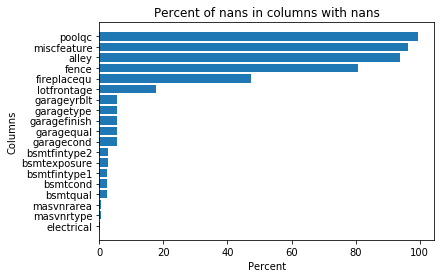

In [36]:
# see percent of nan values within each column
nan_col = housing_df.isnull().sum()/ len(housing_df)*100
nan_col = nan_col.drop(nan_col[nan_col == 0].index).sort_values(ascending=True)
plt.barh(nan_col.keys(),nan_col.values)
plt.title('Percent of nans in columns with nans')
plt.ylabel('Columns')
plt.xlabel('Percent')
plt.show()

Categorical columns with nans can be just filled with the string "None". This is only the case if the nan values represents an absence of that feature within the house (e.g. Nan value in fence column = No fence). 

The nans within numeric columns such as garageyrblt (garage year built) and masvnrarea (Masonry veneer area in square feet), can be replaced with zeros since nans within those columns are likely to also represent an absence of those features. 

Looking at a great [notebook](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) created by Serigne, I used his idea of using mean imputation for the lot frontage column (Linear feet of street connected to property) ordered by neighborhood. This makes sense since houses within the same neighborhood are likely to have the same lot frontage. 

In [37]:
fill_none_col = ['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'garagetype', 
                 'garagefinish', 'garagequal', 'garagecond', 'bsmtqual', 'bsmtcond', 'bsmtexposure',
                 'bsmtfintype1', 'bsmtfintype2', 'masvnrtype', 'electrical']
for col in fill_none_col:
    housing_df[col] = housing_df[col].fillna('None')

fill_zero_col = ['garageyrblt', 'masvnrarea']
for col in fill_zero_col:
    housing_df[col] = housing_df[col].fillna(0)
    
housing_df['lotfrontage'] = housing_df.groupby("neighborhood")["lotfrontage"].transform(
    lambda x: x.fillna(x.median()))



### Dummy Variables

In [38]:
# create dummy variables for categorical features
binary_count = 0
for col in housing_df.columns:
    # create dummy variables for binary features
    if (housing_df[col].dtype == 'O') and (len(housing_df[col].value_counts()) == 2):
        binary_col = housing_df[col].value_counts().keys()[0]
        housing_df["is_" + binary_col] = pd.get_dummies(housing_df[col], drop_first=True)
        binary_count += 1
        housing_df.drop(col, axis=1, inplace=True)
    # create dummy variables for other multi-category features
    elif (housing_df[col].dtype == 'O') and (len(housing_df[col].value_counts()) != 2):
        housing_df = pd.concat([housing_df, pd.get_dummies(housing_df[col], prefix=col)], axis=1)
        binary_count += 1
        housing_df.drop(col, axis=1, inplace=True)

### Outliers

As we can see below, the difference between the max value and the 75% percentile of some numeric features is significantly large. Those feature's respective max values are likely to be outlier.

In [39]:
housing_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,is_Pave,alley_Grvl,alley_None,alley_Pave,lotshape_IR1,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_Bnk,landcontour_HLS,landcontour_Low,landcontour_Lvl,is_AllPub,lotconfig_Corner,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_Gtl,landslope_Mod,landslope_Sev,neighborhood_Blmngtn,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,...,electrical_Mix,electrical_None,electrical_SBrkr,kitchenqual_Ex,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj1,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,fireplacequ_Ex,fireplacequ_Fa,fireplacequ_Gd,fireplacequ_None,fireplacequ_Po,fireplacequ_TA,garagetype_2Types,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_None,garagefinish_Fin,garagefinish_None,garagefinish_RFn,garagefinish_Unf,garagequal_Ex,garagequal_Fa,garagequal_Gd,garagequal_None,garagequal_Po,garagequal_TA,garagecond_Ex,garagecond_Fa,garagecond_Gd,garagecond_None,garagecond_Po,garagecond_TA,paveddrive_N,paveddrive_P,paveddrive_Y,poolqc_Ex,poolqc_Fa,poolqc_Gd,poolqc_None,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,fence_None,miscfeature_Gar2,miscfeature_None,miscfeature_Othr,miscfeature_Shed,miscfeature_TenC,saletype_COD,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.199658,1

The turkey method is used to find the outliers that are beyond a threshold outside of the 25th or 75th percentile. Observations that are beyond that threshold are capped at the max/min threshold value using the winsorize method.

In [46]:
housing_df.yearbuilt = housing_df.yearbuilt.replace(0, np.nan)
housing_df.yearbuilt = housing_df.yearbuilt.fillna(housing_df.yearbuilt.mean())

mssubclass
Feature: mssubclass ... outliers: 103 ... percentage 7.054794520547945


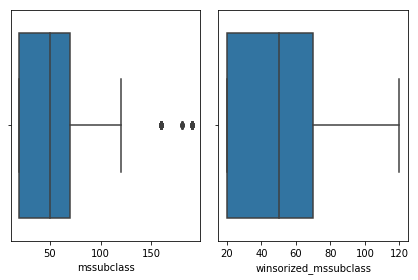

lotfrontage
Feature: lotfrontage ... outliers: 93 ... percentage 6.36986301369863


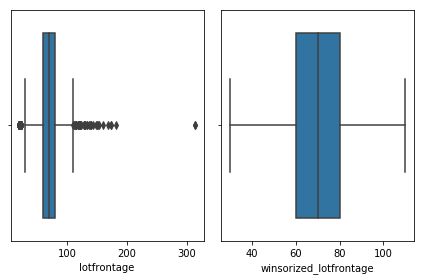

lotarea
Feature: lotarea ... outliers: 69 ... percentage 4.726027397260274


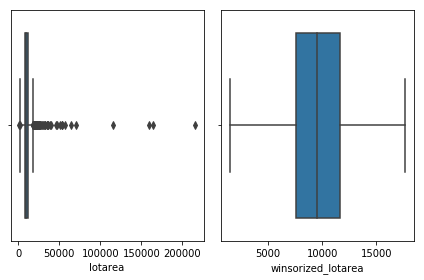

overallqual
Feature: overallqual ... outliers: 2 ... percentage 0.136986301369863


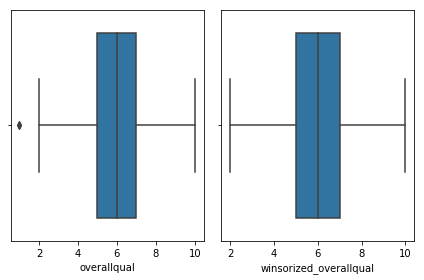

overallcond
Feature: overallcond ... outliers: 125 ... percentage 8.561643835616438


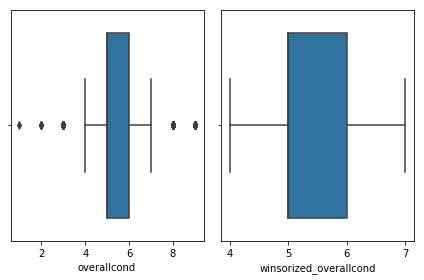

yearbuilt
Feature: yearbuilt ... outliers: 7 ... percentage 0.4794520547945206


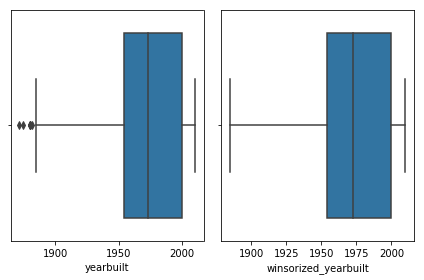

yearremodadd
Feature: yearremodadd ... outliers: 0 ... percentage 0.0


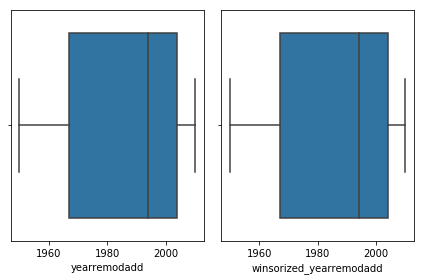

masvnrarea
Feature: masvnrarea ... outliers: 28 ... percentage 1.9178082191780823


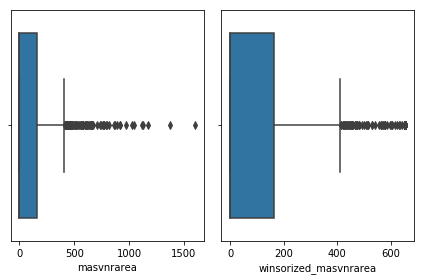

bsmtfinsf1
Feature: bsmtfinsf1 ... outliers: 7 ... percentage 0.4794520547945206


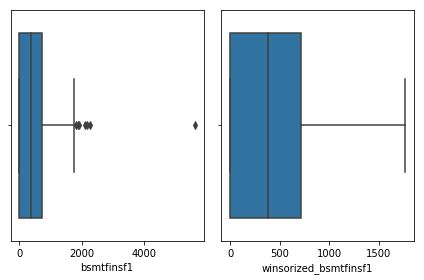

bsmtfinsf2
Feature: bsmtfinsf2 ... outliers: 3 ... percentage 0.2054794520547945


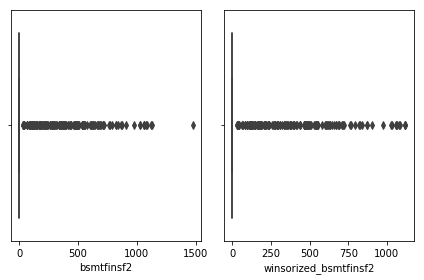

bsmtunfsf
Feature: bsmtunfsf ... outliers: 29 ... percentage 1.9863013698630139


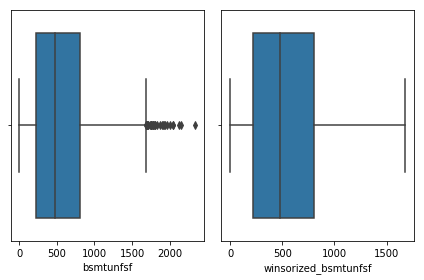

totalbsmtsf
Feature: totalbsmtsf ... outliers: 61 ... percentage 4.178082191780822


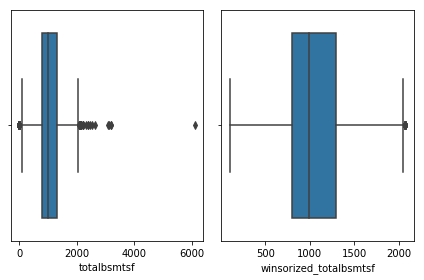

firstflrsf
Feature: firstflrsf ... outliers: 20 ... percentage 1.36986301369863


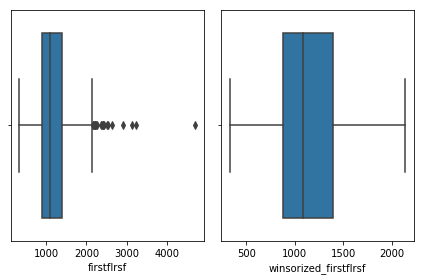

secondflrsf
Feature: secondflrsf ... outliers: 17 ... percentage 1.1643835616438356


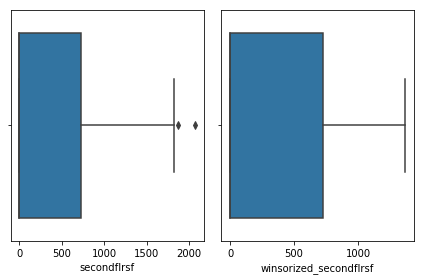

lowqualfinsf
Feature: lowqualfinsf ... outliers: 0 ... percentage 0.0


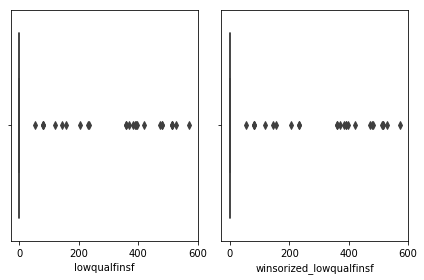

grlivarea
Feature: grlivarea ... outliers: 31 ... percentage 2.1232876712328768


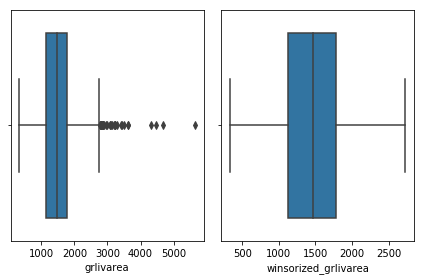

bsmtfullbath
Feature: bsmtfullbath ... outliers: 16 ... percentage 1.095890410958904


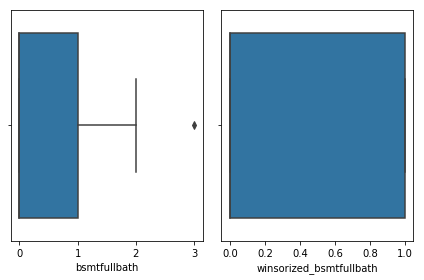

bsmthalfbath
Feature: bsmthalfbath ... outliers: 2 ... percentage 0.136986301369863


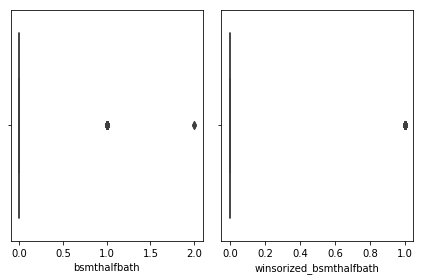

fullbath
Feature: fullbath ... outliers: 0 ... percentage 0.0


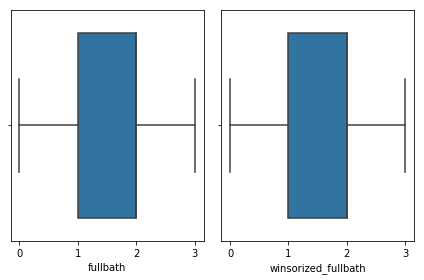

halfbath
Feature: halfbath ... outliers: 12 ... percentage 0.821917808219178


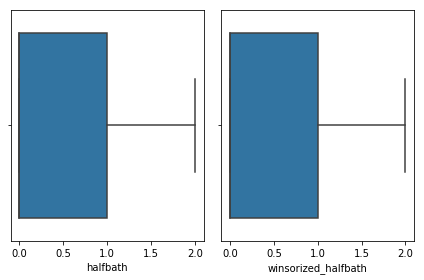

bedroomabvgr
Feature: bedroomabvgr ... outliers: 35 ... percentage 2.3972602739726026


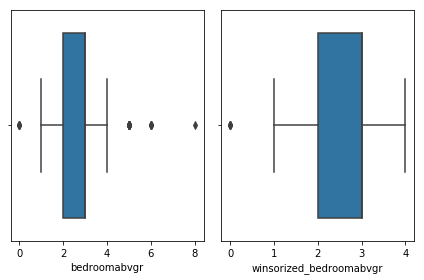

kitchenabvgr


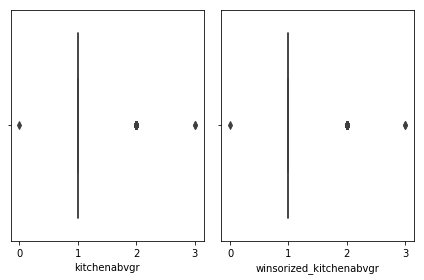

totrmsabvgrd
Feature: totrmsabvgrd ... outliers: 30 ... percentage 2.054794520547945


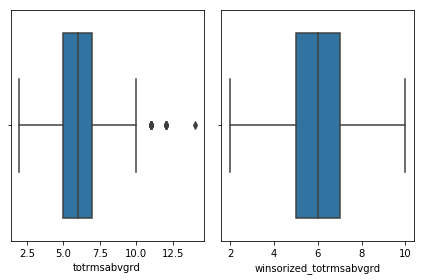

fireplaces
Feature: fireplaces ... outliers: 5 ... percentage 0.3424657534246575


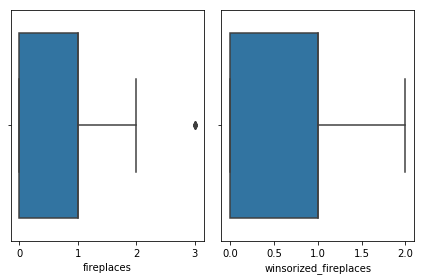

garageyrblt
Feature: garageyrblt ... outliers: 81 ... percentage 5.5479452054794525


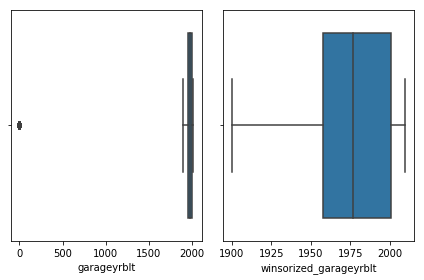

garagecars
Feature: garagecars ... outliers: 5 ... percentage 0.3424657534246575


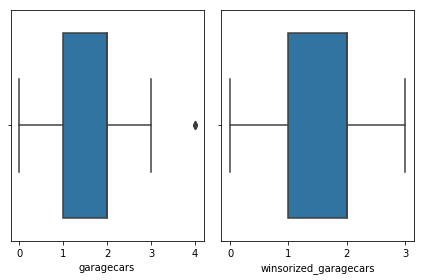

garagearea
Feature: garagearea ... outliers: 21 ... percentage 1.4383561643835616


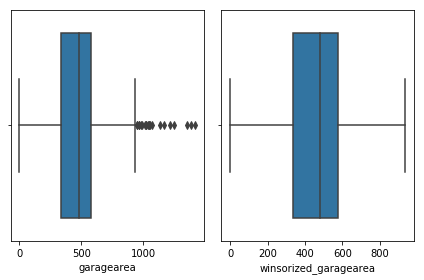

wooddecksf
Feature: wooddecksf ... outliers: 32 ... percentage 2.191780821917808


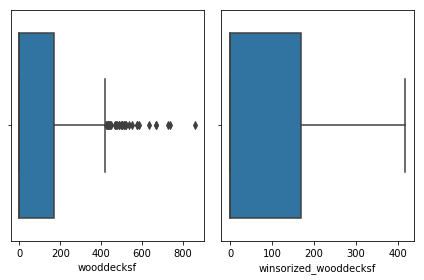

openporchsf
Feature: openporchsf ... outliers: 77 ... percentage 5.273972602739726


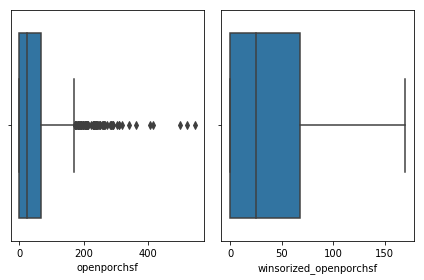

enclosedporch
Feature: enclosedporch ... outliers: 2 ... percentage 0.136986301369863


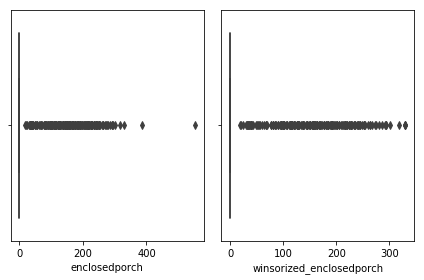

threessnporch
Feature: threessnporch ... outliers: 2 ... percentage 0.136986301369863


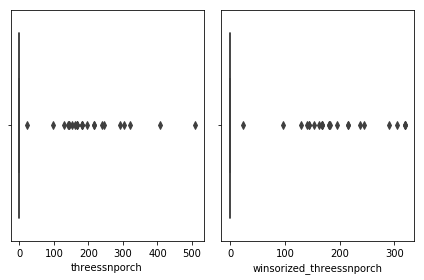

screenporch
Feature: screenporch ... outliers: 6 ... percentage 0.410958904109589


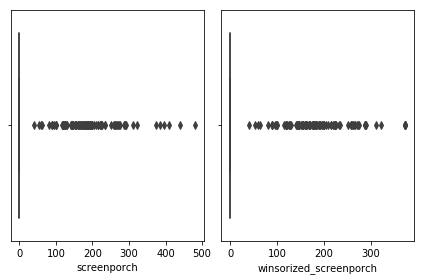

poolarea
Feature: poolarea ... outliers: 0 ... percentage 0.0


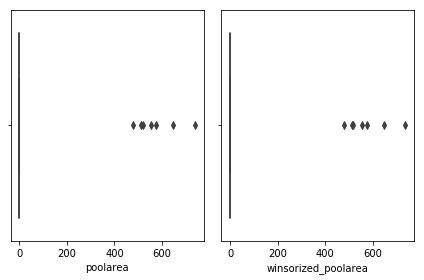

miscval
Feature: miscval ... outliers: 8 ... percentage 0.547945205479452


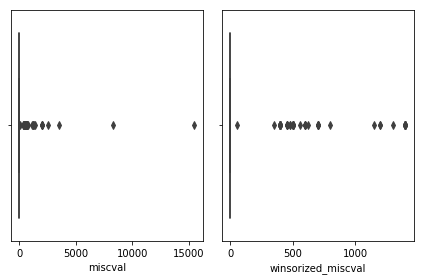

mosold
Feature: mosold ... outliers: 0 ... percentage 0.0


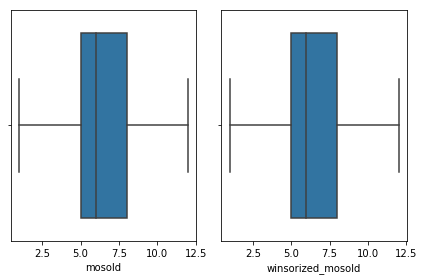

yrsold
Feature: yrsold ... outliers: 0 ... percentage 0.0


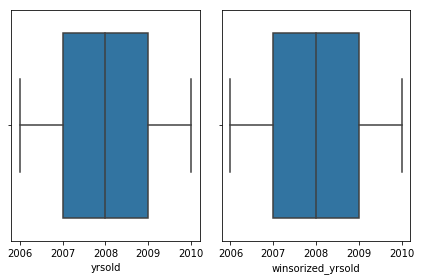

saleprice
Feature: saleprice ... outliers: 61 ... percentage 4.178082191780822


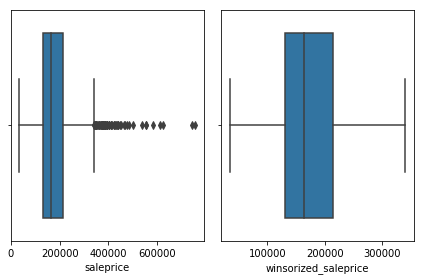

winsorized_mssubclass
Feature: winsorized_mssubclass ... outliers: 0 ... percentage 0.0


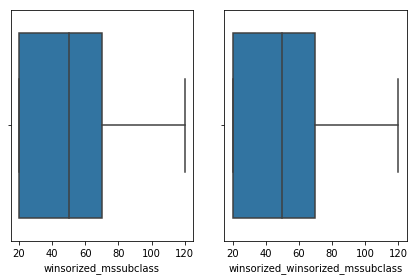

winsorized_lotfrontage
Feature: winsorized_lotfrontage ... outliers: 0 ... percentage 0.0


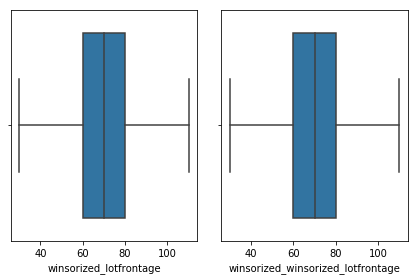

winsorized_lotarea
Feature: winsorized_lotarea ... outliers: 0 ... percentage 0.0


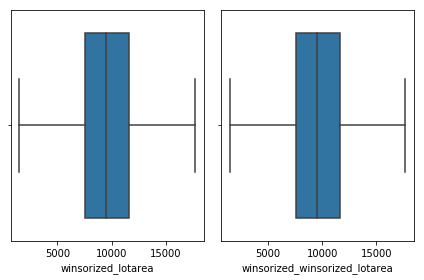

winsorized_overallqual
Feature: winsorized_overallqual ... outliers: 0 ... percentage 0.0


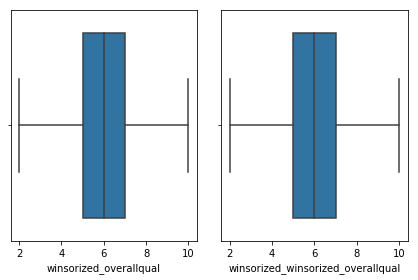

winsorized_overallcond
Feature: winsorized_overallcond ... outliers: 0 ... percentage 0.0


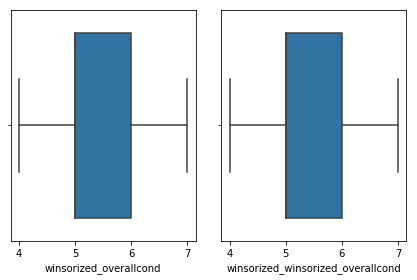

winsorized_yearbuilt
Feature: winsorized_yearbuilt ... outliers: 0 ... percentage 0.0


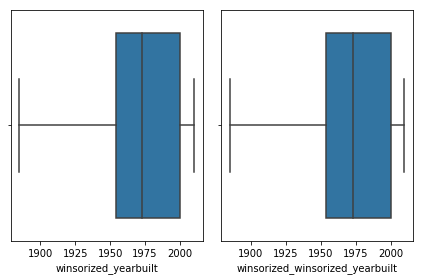

winsorized_yearremodadd
Feature: winsorized_yearremodadd ... outliers: 0 ... percentage 0.0


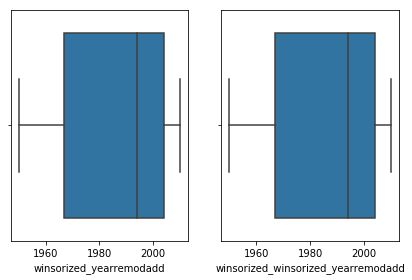

winsorized_masvnrarea
Feature: winsorized_masvnrarea ... outliers: 0 ... percentage 0.0


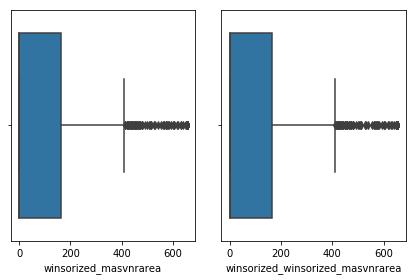

winsorized_bsmtfinsf1
Feature: winsorized_bsmtfinsf1 ... outliers: 0 ... percentage 0.0


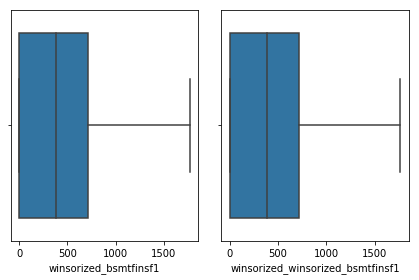

winsorized_bsmtfinsf2
Feature: winsorized_bsmtfinsf2 ... outliers: 3 ... percentage 0.2054794520547945


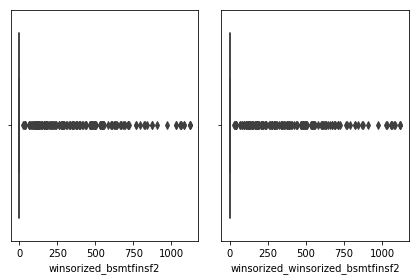

winsorized_bsmtunfsf
Feature: winsorized_bsmtunfsf ... outliers: 0 ... percentage 0.0


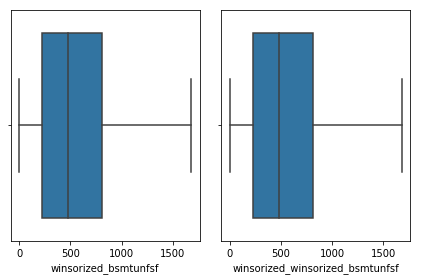

winsorized_totalbsmtsf
Feature: winsorized_totalbsmtsf ... outliers: 24 ... percentage 1.643835616438356


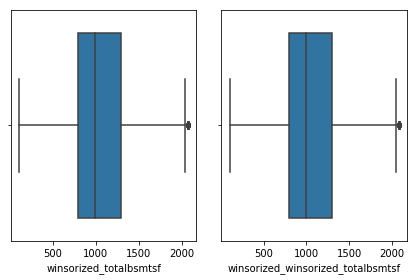

winsorized_firstflrsf
Feature: winsorized_firstflrsf ... outliers: 0 ... percentage 0.0


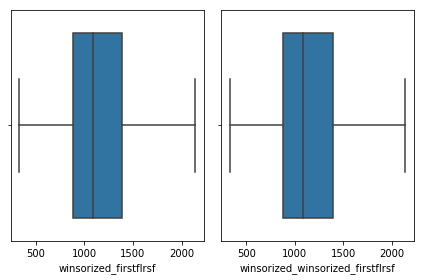

winsorized_secondflrsf
Feature: winsorized_secondflrsf ... outliers: 0 ... percentage 0.0


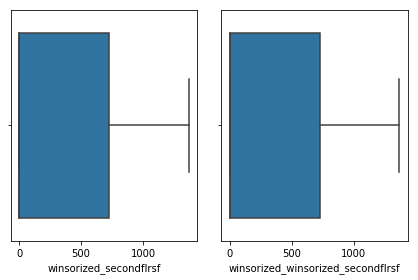

winsorized_lowqualfinsf
Feature: winsorized_lowqualfinsf ... outliers: 0 ... percentage 0.0


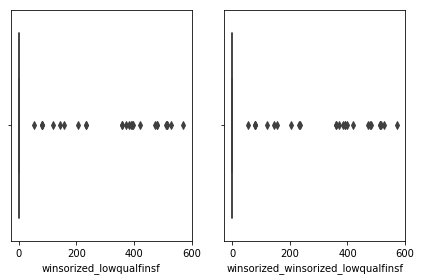

winsorized_grlivarea
Feature: winsorized_grlivarea ... outliers: 0 ... percentage 0.0


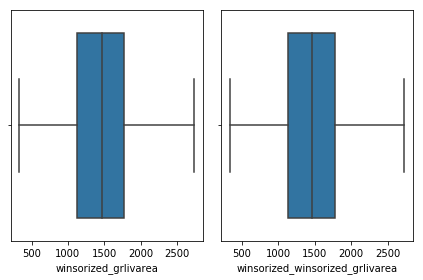

winsorized_bsmtfullbath
Feature: winsorized_bsmtfullbath ... outliers: 0 ... percentage 0.0


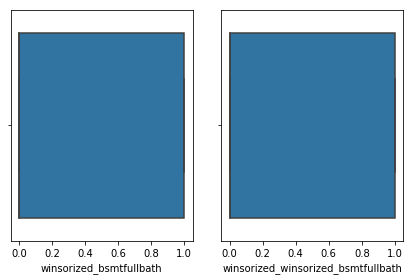

winsorized_bsmthalfbath
Feature: winsorized_bsmthalfbath ... outliers: 0 ... percentage 0.0


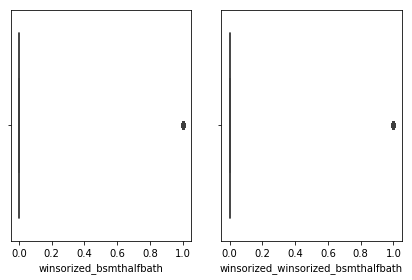

winsorized_fullbath
Feature: winsorized_fullbath ... outliers: 0 ... percentage 0.0


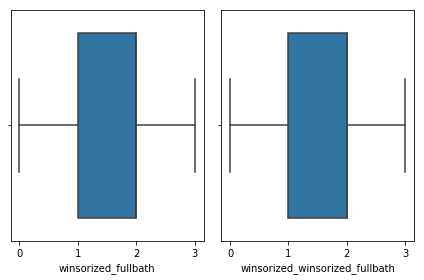

winsorized_halfbath
Feature: winsorized_halfbath ... outliers: 12 ... percentage 0.821917808219178


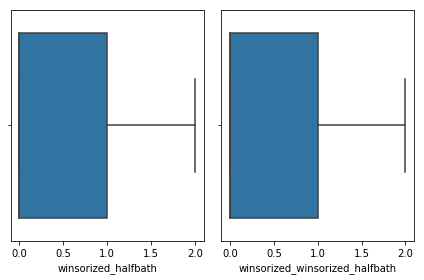

winsorized_bedroomabvgr
Feature: winsorized_bedroomabvgr ... outliers: 6 ... percentage 0.410958904109589


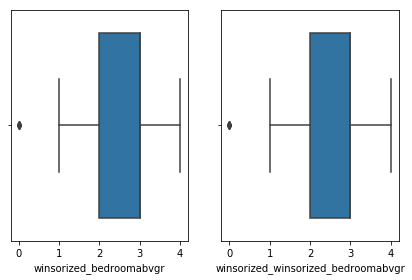

winsorized_kitchenabvgr
Feature: winsorized_kitchenabvgr ... outliers: 68 ... percentage 4.657534246575342


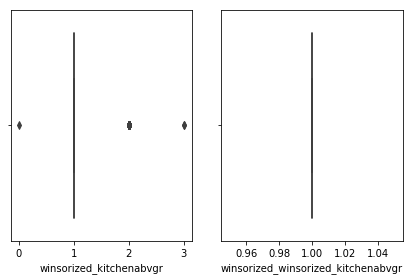

winsorized_totrmsabvgrd
Feature: winsorized_totrmsabvgrd ... outliers: 0 ... percentage 0.0


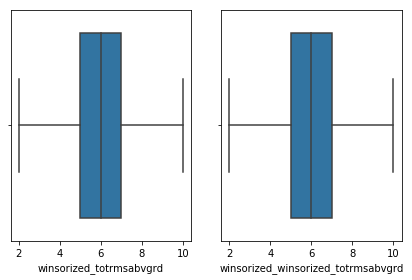

winsorized_fireplaces
Feature: winsorized_fireplaces ... outliers: 0 ... percentage 0.0


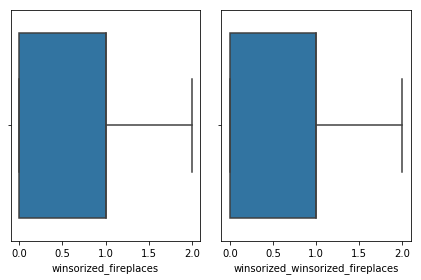

winsorized_garageyrblt
Feature: winsorized_garageyrblt ... outliers: 0 ... percentage 0.0


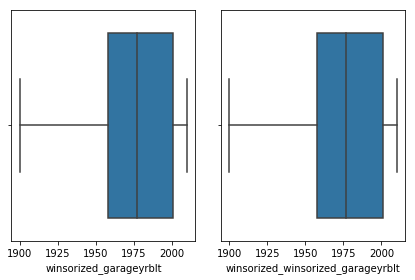

winsorized_garagecars
Feature: winsorized_garagecars ... outliers: 0 ... percentage 0.0


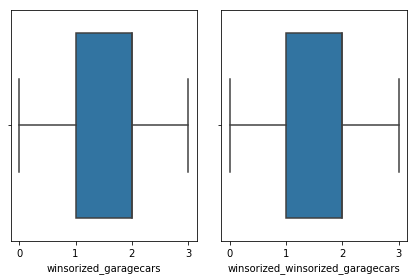

winsorized_garagearea
Feature: winsorized_garagearea ... outliers: 0 ... percentage 0.0


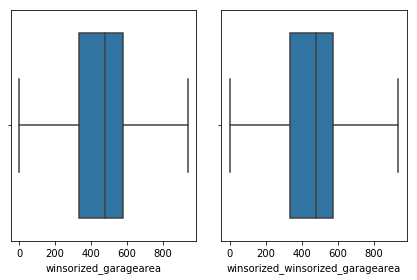

winsorized_wooddecksf
Feature: winsorized_wooddecksf ... outliers: 0 ... percentage 0.0


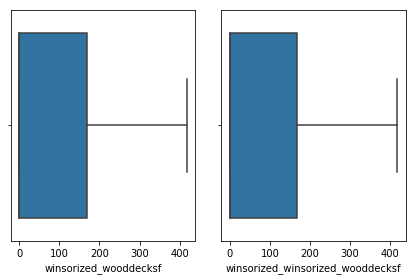

winsorized_openporchsf
Feature: winsorized_openporchsf ... outliers: 0 ... percentage 0.0


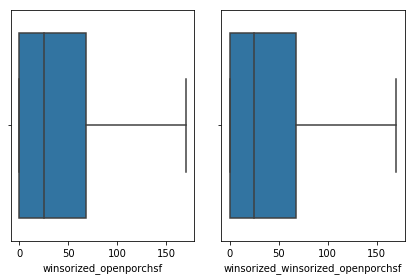

winsorized_enclosedporch
Feature: winsorized_enclosedporch ... outliers: 0 ... percentage 0.0


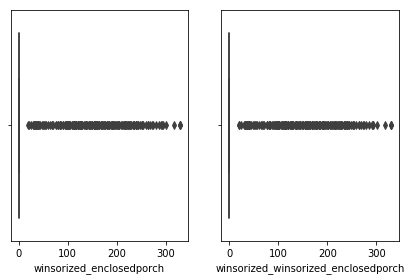

winsorized_threessnporch
Feature: winsorized_threessnporch ... outliers: 0 ... percentage 0.0


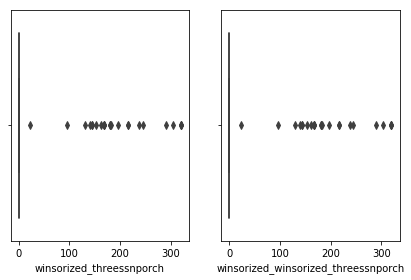

winsorized_screenporch
Feature: winsorized_screenporch ... outliers: 6 ... percentage 0.410958904109589


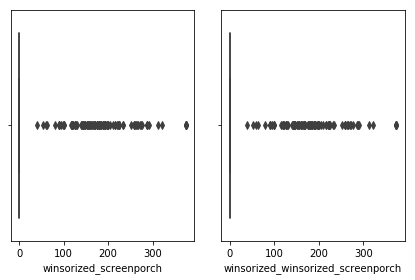

winsorized_poolarea
Feature: winsorized_poolarea ... outliers: 0 ... percentage 0.0


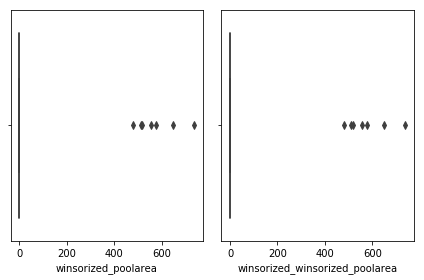

winsorized_miscval
Feature: winsorized_miscval ... outliers: 0 ... percentage 0.0


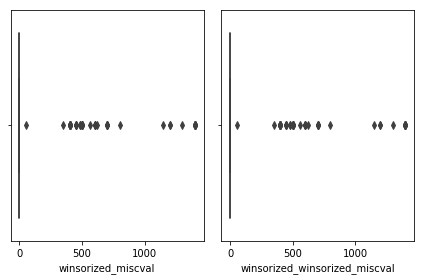

winsorized_mosold
Feature: winsorized_mosold ... outliers: 0 ... percentage 0.0


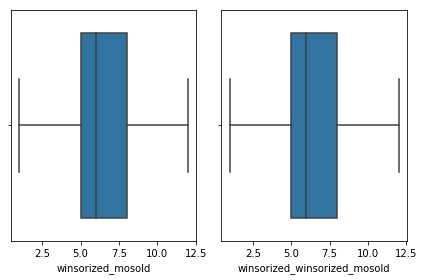

winsorized_yrsold
Feature: winsorized_yrsold ... outliers: 0 ... percentage 0.0


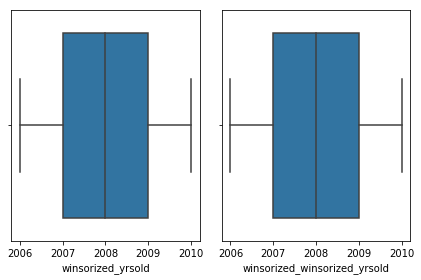

winsorized_saleprice
Feature: winsorized_saleprice ... outliers: 0 ... percentage 0.0


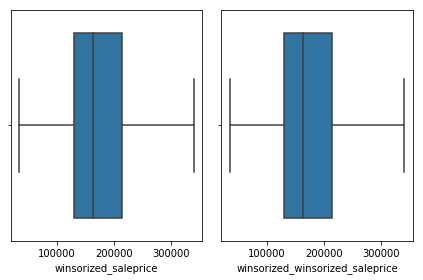

winsorized_winsorized_mssubclass
Feature: winsorized_winsorized_mssubclass ... outliers: 0 ... percentage 0.0


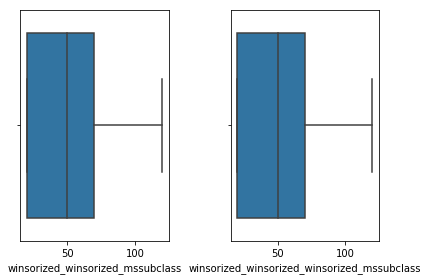

winsorized_winsorized_lotfrontage
Feature: winsorized_winsorized_lotfrontage ... outliers: 0 ... percentage 0.0


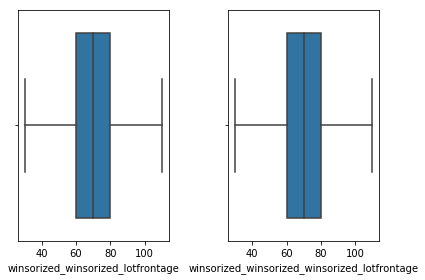

winsorized_winsorized_lotarea
Feature: winsorized_winsorized_lotarea ... outliers: 0 ... percentage 0.0


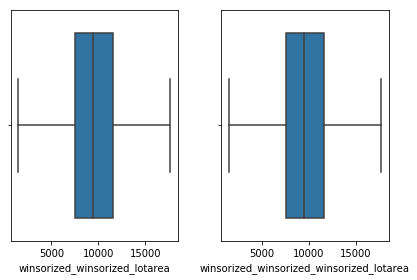

winsorized_winsorized_overallqual
Feature: winsorized_winsorized_overallqual ... outliers: 0 ... percentage 0.0


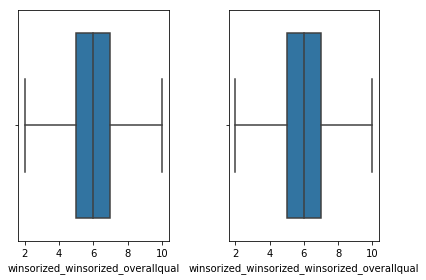

winsorized_winsorized_overallcond
Feature: winsorized_winsorized_overallcond ... outliers: 0 ... percentage 0.0


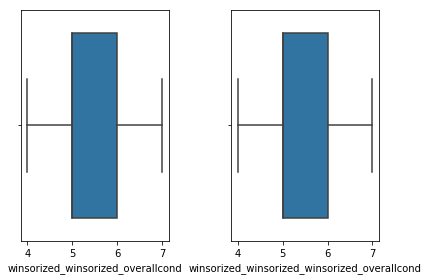

winsorized_winsorized_yearbuilt
Feature: winsorized_winsorized_yearbuilt ... outliers: 0 ... percentage 0.0


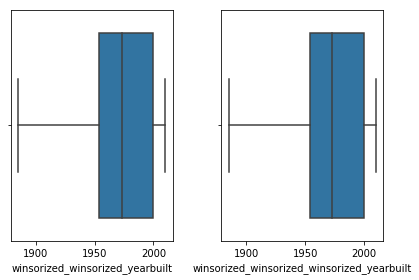

winsorized_winsorized_yearremodadd
Feature: winsorized_winsorized_yearremodadd ... outliers: 0 ... percentage 0.0


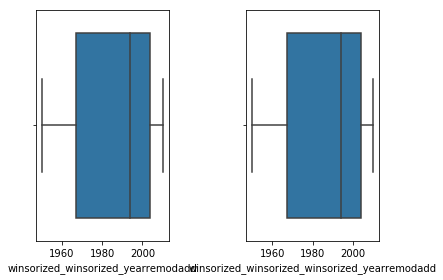

winsorized_winsorized_masvnrarea
Feature: winsorized_winsorized_masvnrarea ... outliers: 0 ... percentage 0.0


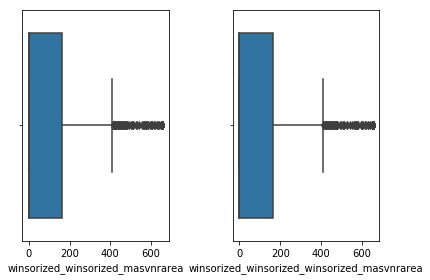

winsorized_winsorized_bsmtfinsf1
Feature: winsorized_winsorized_bsmtfinsf1 ... outliers: 0 ... percentage 0.0


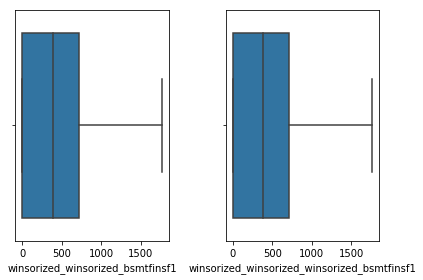

winsorized_winsorized_bsmtfinsf2
Feature: winsorized_winsorized_bsmtfinsf2 ... outliers: 3 ... percentage 0.2054794520547945


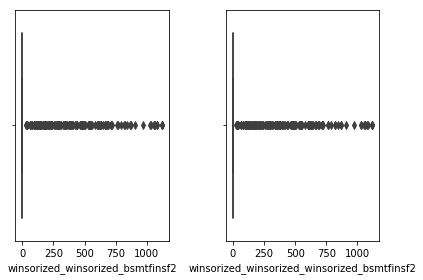

winsorized_winsorized_bsmtunfsf
Feature: winsorized_winsorized_bsmtunfsf ... outliers: 0 ... percentage 0.0


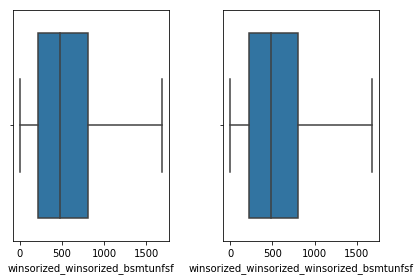

winsorized_winsorized_totalbsmtsf
Feature: winsorized_winsorized_totalbsmtsf ... outliers: 24 ... percentage 1.643835616438356


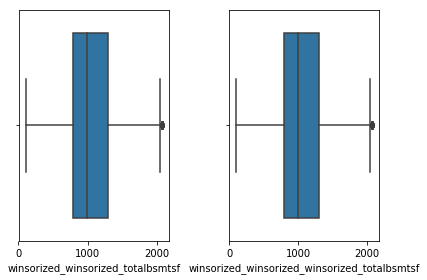

winsorized_winsorized_firstflrsf
Feature: winsorized_winsorized_firstflrsf ... outliers: 0 ... percentage 0.0


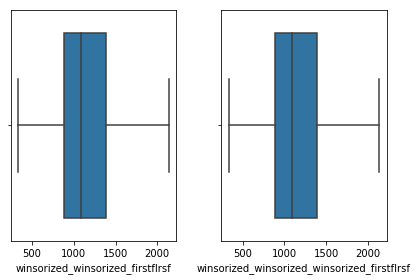

winsorized_winsorized_secondflrsf
Feature: winsorized_winsorized_secondflrsf ... outliers: 0 ... percentage 0.0


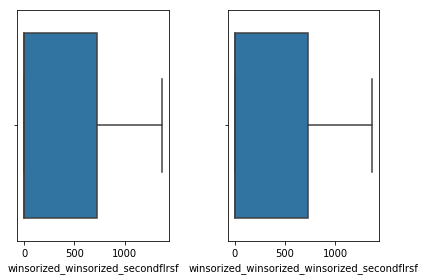

winsorized_winsorized_lowqualfinsf
Feature: winsorized_winsorized_lowqualfinsf ... outliers: 0 ... percentage 0.0


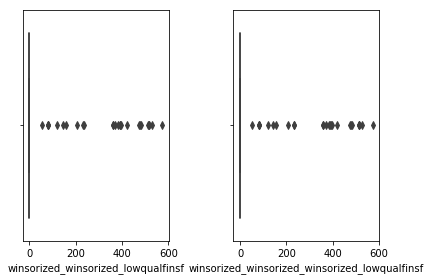

winsorized_winsorized_grlivarea
Feature: winsorized_winsorized_grlivarea ... outliers: 0 ... percentage 0.0


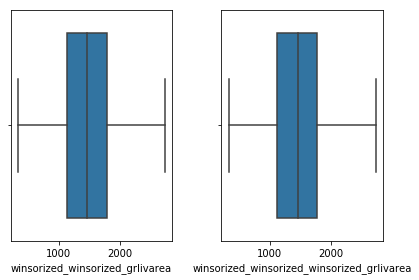

winsorized_winsorized_bsmtfullbath
Feature: winsorized_winsorized_bsmtfullbath ... outliers: 0 ... percentage 0.0


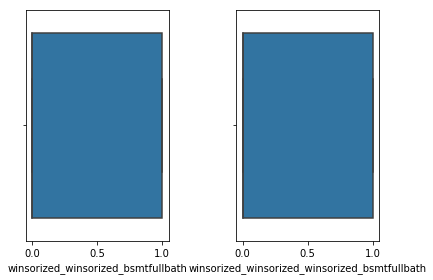

winsorized_winsorized_bsmthalfbath
Feature: winsorized_winsorized_bsmthalfbath ... outliers: 0 ... percentage 0.0


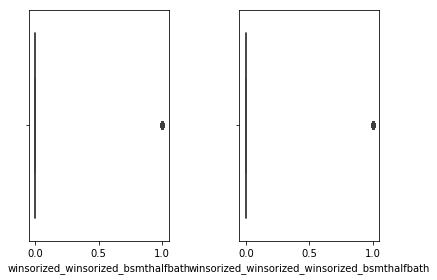

winsorized_winsorized_fullbath
Feature: winsorized_winsorized_fullbath ... outliers: 0 ... percentage 0.0


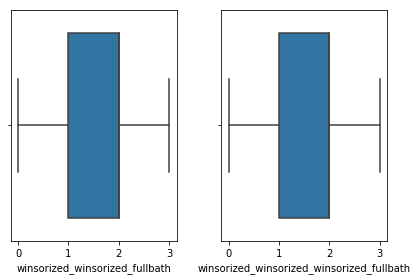

winsorized_winsorized_halfbath
Feature: winsorized_winsorized_halfbath ... outliers: 12 ... percentage 0.821917808219178


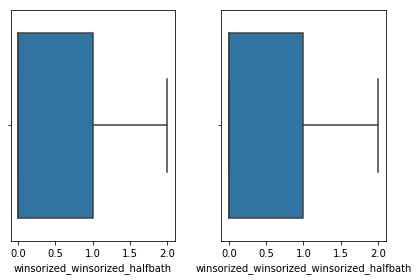

winsorized_winsorized_bedroomabvgr
Feature: winsorized_winsorized_bedroomabvgr ... outliers: 6 ... percentage 0.410958904109589


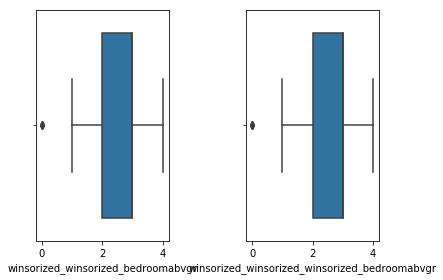

winsorized_winsorized_kitchenabvgr
Feature: winsorized_winsorized_kitchenabvgr ... outliers: 0 ... percentage 0.0


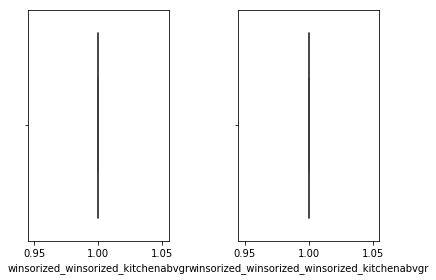

winsorized_winsorized_totrmsabvgrd
Feature: winsorized_winsorized_totrmsabvgrd ... outliers: 0 ... percentage 0.0


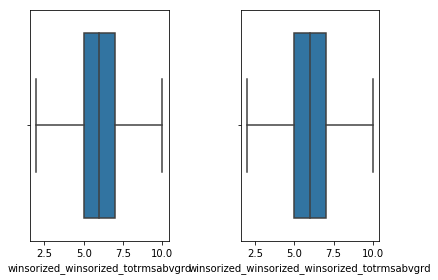

winsorized_winsorized_fireplaces
Feature: winsorized_winsorized_fireplaces ... outliers: 0 ... percentage 0.0


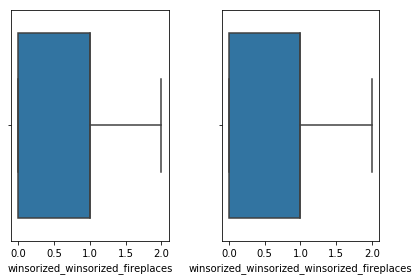

winsorized_winsorized_garageyrblt
Feature: winsorized_winsorized_garageyrblt ... outliers: 0 ... percentage 0.0


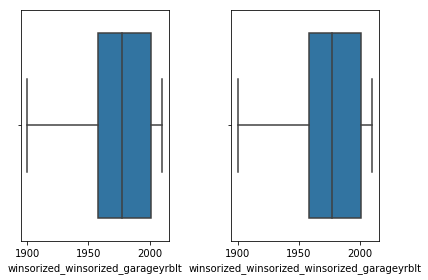

winsorized_winsorized_garagecars
Feature: winsorized_winsorized_garagecars ... outliers: 0 ... percentage 0.0


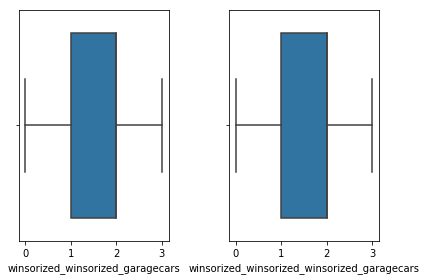

winsorized_winsorized_garagearea
Feature: winsorized_winsorized_garagearea ... outliers: 0 ... percentage 0.0


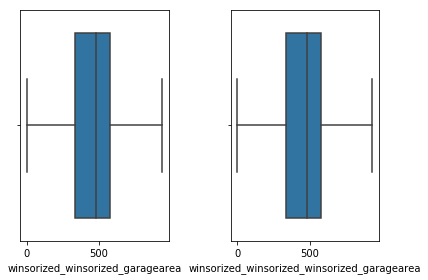

winsorized_winsorized_wooddecksf
Feature: winsorized_winsorized_wooddecksf ... outliers: 0 ... percentage 0.0


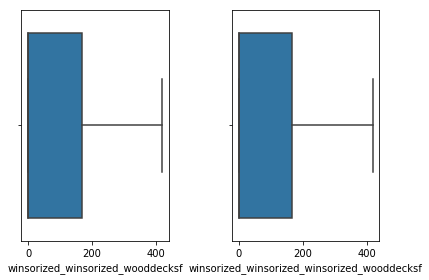

winsorized_winsorized_openporchsf
Feature: winsorized_winsorized_openporchsf ... outliers: 0 ... percentage 0.0


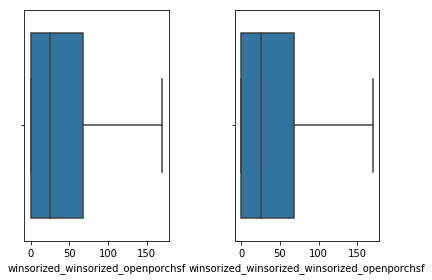

winsorized_winsorized_enclosedporch
Feature: winsorized_winsorized_enclosedporch ... outliers: 0 ... percentage 0.0


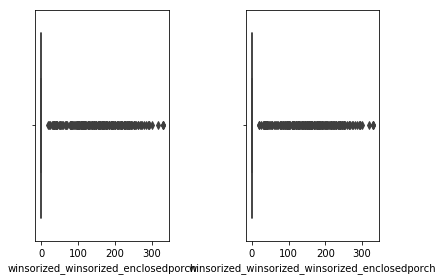

winsorized_winsorized_threessnporch
Feature: winsorized_winsorized_threessnporch ... outliers: 0 ... percentage 0.0


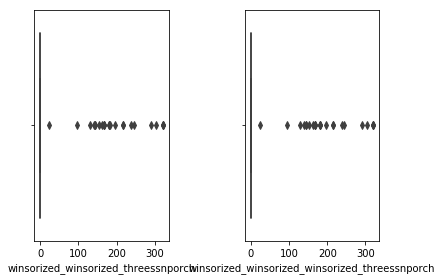

winsorized_winsorized_screenporch
Feature: winsorized_winsorized_screenporch ... outliers: 6 ... percentage 0.410958904109589


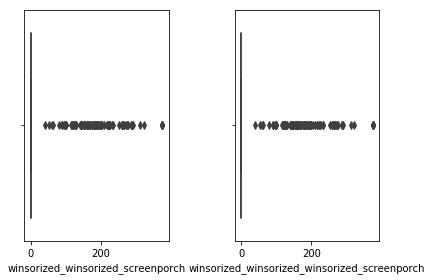

winsorized_winsorized_poolarea
Feature: winsorized_winsorized_poolarea ... outliers: 0 ... percentage 0.0


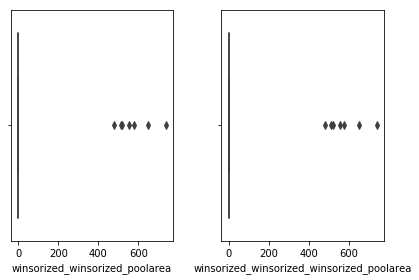

winsorized_winsorized_miscval
Feature: winsorized_winsorized_miscval ... outliers: 0 ... percentage 0.0


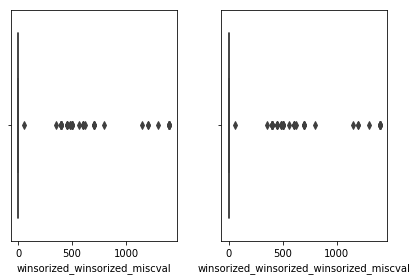

winsorized_winsorized_mosold
Feature: winsorized_winsorized_mosold ... outliers: 0 ... percentage 0.0


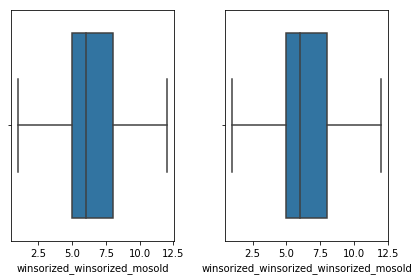

winsorized_winsorized_yrsold
Feature: winsorized_winsorized_yrsold ... outliers: 0 ... percentage 0.0


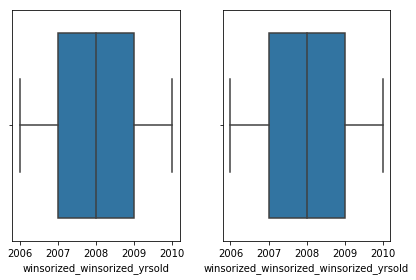

winsorized_winsorized_saleprice
Feature: winsorized_winsorized_saleprice ... outliers: 0 ... percentage 0.0


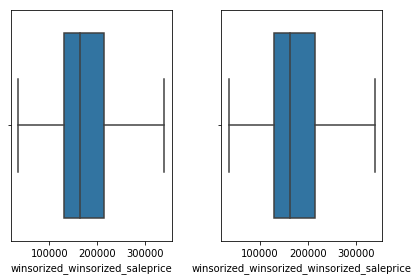

In [47]:
num_col = [col for col in housing_df.columns if (housing_df[col].dtypes == 'int64') or (housing_df[col].dtypes == 'float64')]

for num in range(1, len(num_col)):
    print(num_col[num])
    if num_col[num] != 'kitchenabvgr':
        if housing_df[num_col[num]].median() == 0:
            data = housing_df[num_col[num]][housing_df[num_col[num]] != 0]
            q25, q75 = np.percentile(data, [25,75])
            iqr = q75 - q25
            min_val = 0
            max_val = q75 + (iqr*1.5)

        else:
            data = housing_df[num_col[num]]
            q25, q75 = np.percentile(data, [25,75])
            iqr = q75 - q25
            min_val = q25 - (iqr*1.5)
            max_val = q75 + (iqr*1.5)


        min_outliers, max_outliers = len(np.where(housing_df[num_col[num]] < min_val)[0]), len(np.where(housing_df[num_col[num]] > max_val)[0])
        total_outliers = min_outliers + max_outliers
        min_pct, max_pct = min_outliers/len(housing_df), max_outliers/len(housing_df)
        total_pct_outliers = total_outliers /len(housing_df) * 100
        housing_df['winsorized_'+ num_col[num]] = winsorize(housing_df[num_col[num]], (min_pct, max_pct))
        
        print("Feature: {} ... outliers: {} ... percentage {}".format(''.join([num_col[num]]), total_outliers, total_pct_outliers))
    else:
        housing_df['winsorized_'+ num_col[num]] = housing_df[num_col[num]]
    
    plt.subplot(1,2,1)
    sns.boxplot(housing_df[num_col[num]])
    
    plt.subplot(1,2,2)
    sns.boxplot(housing_df['winsorized_'+ num_col[num]])
    
    plt.tight_layout()
    plt.show()

## Feature Visualizations

According to [Homeia](https://homeia.com/10-important-features-to-consider-when-buying-a-house/), some of the most important factors for house prices are:

- Location
- Square Feet
- Number of bedrooms/bathrooms
- House quality interior/exterior
- Year Built

Lets see if these specific features or other features have a strong correlation with sale price.

/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(obj)


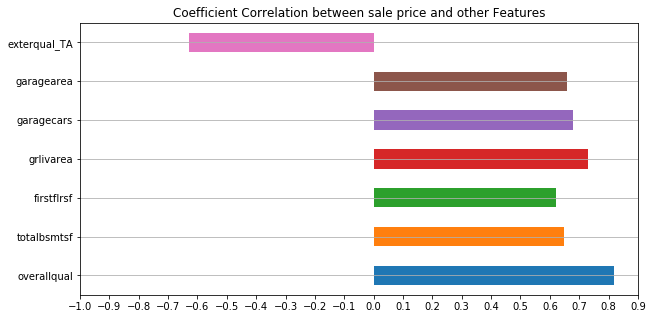

In [369]:
# plot features with coefficient correlations stronger than .5 in regards to sale price.
corr = housing_df.corr()
plot_corr = corr[(corr.saleprice > .6) | (corr.saleprice < -.6)]
plot_corr = plot_corr.saleprice
plot_corr.drop('saleprice', inplace=True)

plt.figure(figsize=(10, 5))
plot_corr.plot(kind='barh', grid=True)
plt.grid(axis='x')
plt.title('Coefficient Correlation between sale price and other Features')
plt.xticks(np.arange(-1, 1, .1))
plt.show()

The overallqual variable (Overall material and finish quality) had the strongest correlation with sale price. In addition, exterqual_TA had a somewhat strong correlation with sale price. These two variables relates to the house quality interior/exterior factor mentioned above in the list. 

The grlivarea (total above ground living area square feet), firstflrsf (first floor square feet) and totalbsmtsf (total basement square feet) all had a somewhat strong correlation with sale price. Since first floor square feet is proportional to above ground square feet, we can just keep above ground living area for the modeling process. 

We can also assume that garagearea and garagecars are proportional to one another so we can exclude one of them within the modeling process.  

Surprisingly location and number of bedrooms/bathrooms were not strongly correlated with sale price. The bedrooms/bathrooms variables will be kept since there may be a transformation that could spark a correlation with sale price. 

# Feature Engineering

In [370]:
# combine related variables from above

housing_df['total_sf'] = housing_df.totalbsmtsf + housing_df.grlivarea + housing_df.garagearea 
+ housing_df.wooddecksf + housing_df.openporchsf + housing_df.poolarea

housing_df['total_fullbaths'] = housing_df.bsmtfullbath + housing_df.fullbath
housing_df['total_halfbaths'] = housing_df.bsmthalfbath + housing_df.halfbath

In [371]:
housing_df.describe()['total_sf']

count    1460.000000
mean     3026.245890
std       870.562422
min       439.000000
25%      2396.750000
50%      2937.500000
75%      3575.750000
max      5742.000000
Name: total_sf, dtype: float64

(array([  1.,  32., 116., 326., 364., 272., 179., 100.,  53.,  17.]),
 array([ 439. ,  969.3, 1499.6, 2029.9, 2560.2, 3090.5, 3620.8, 4151.1,
        4681.4, 5211.7, 5742. ]),
 <a list of 10 Patch objects>)

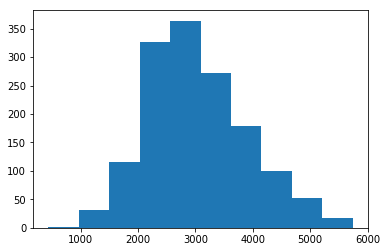

In [372]:
plt.hist(housing_df['total_sf'])

In [373]:
feature_list = ['overallqual', 'total_sf',
                'total_fullbaths', 'total_halfbaths']

housing_df[feature_list].head()

,overallqual,total_sf,total_fullbaths,total_halfbaths
0,7,3114,3,1
1,6,2984,2,0
2,7,3314,3,1
3,7,3115,2,0
4,8,4179,3,1


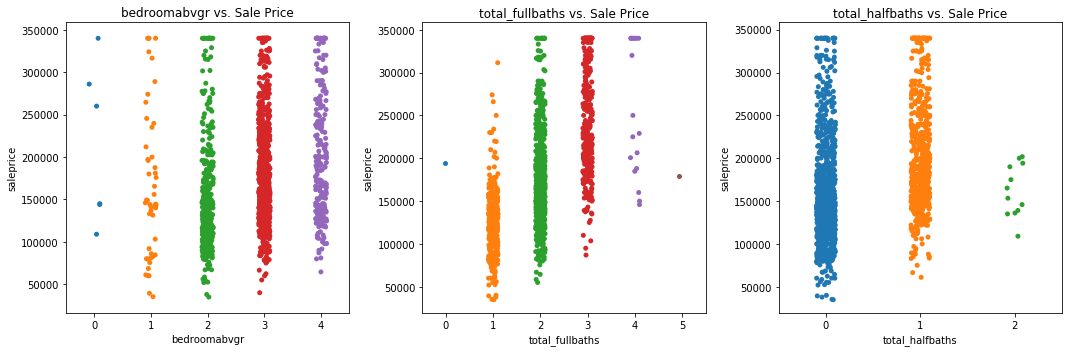

In [374]:
def categorical_plot(df, columns, n_cols=2):
    plt.figure(figsize=(15, 5))
    n_rows = len(columns) / n_cols
    for i in range(1, len(columns)+1):
        plt.subplot(n_rows, n_cols, i)
        sns.stripplot(housing_df[columns[i-1]],
                      housing_df.saleprice, jitter=True)
        plt.title('{} vs. Sale Price'.format(columns[i-1]))
    plt.tight_layout()


plot_col = ['bedroomabvgr', 'total_fullbaths', 'total_halfbaths']
categorical_plot(housing_df, plot_col, 3)

Using full baths for one feature list as seen in plot.

# Modeling

## Determine Best Model

In [375]:
def model_results(model_list, train_x, train_y, test_x, test_y):
    scoring = ['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_neg_mean_absolute_error',
               'train_neg_mean_absolute_error', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error']

    model_dict = []
    for name, model in model_list.items():
        print(name)
        model_stats = {}
        
        alpha_dict = {'alpha': [.01,.1,1,10,100,1000]}
        if name in ['elastic', 'lasso']:
            model = GridSearchCV(model, alpha_dict, cv=3)
            model.fit(train_x, train_y)
            model_stats['best_alpha'] = model.best_params_['alpha']
            model_stats['coef'] = model.best_estimator_.coef_
        else:
            model.fit(train_x,train_y)
            model_stats['coef'] = np.around(model.coef_)
            if name != 'linear':
                model_stats['best_alpha'] = model.alpha_
        
        pred_y = model.predict(test_x)
        
        model_stats['r2'] = model.score(test_x, test_y)
        model_stats['root_MSE'] = np.sqrt(mse(test_y, pred_y))
        model_stats['MAE'] = np.abs(test_y - pred_y).mean()
        model_stats['MAPE'] = (np.abs(test_y - pred_y) / test_y).mean() * 100
        model_stats['model_name'] = name
        
        
        model_dict.append(model_stats)
            
    model_df = pd.DataFrame(model_dict).set_index('model_name')

    return model_df

In [376]:
feature_list = list(housing_df.loc[:,housing_df.columns != 'saleprice'].columns[1:])

train_x, test_x, train_y, test_y = train_test_split(
    housing_df[feature_list], housing_df['saleprice'], test_size=.2)

elastic = ElasticNet()
ridge = RidgeCV(alphas=(.01,1,10,100,1000))
lasso = Lasso()
linear = LinearRegression()
model_list = {'elastic': elastic, 'ridge': ridge, 'lasso': lasso, 'linear': linear}

model_df = model_results(model_list, train_x, train_y, test_x, test_y)

elastic


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

ridge
lasso


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

linear


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [377]:
model_df

,MAE,MAPE,best_alpha,coef,r2,root_MSE
model_name,,,,,,
elastic,13555.528753,8.343585,0.1,"[-74.44655944390283, 26.67078835606923, 1.1759...",0.894107,22275.182525
ridge,13447.254227,8.246011,10.0,"[-46.0, 4.0, 1.0, 8332.0, 6228.0, 252.0, 176.0...",0.893921,22294.722312
lasso,13312.354040,8.241532,100.0,"[-64.02229252432636, 20.601472703808348, 1.260...",0.901369,21497.851248
linear,15327.913792,9.553270,NaN,"[-13.0, -30.0, 2.0, 7090.0, 5417.0, 301.0, 196...",0.850841,26436.992289


Using all features within the dataset, the linear model performed the best in regards to R^2 score. The Lasso model had the best MAE, MAPE, and root MSE. Although after multiple iterations, the Ridge model was occasionally the top model in regards to MAE, MAPE, and root MSE. Being that 303 features were used for modeling, I would argue that Lasso would be the most appropriate model to use (since Lasso forces smaller coefficients to zero). 

Using only features that had a strong correlation with saleprice, each model performed very similar to one another in regards to all metrics. All regularization models chose the smallest alpha since there was a small amount of features used. The consequence of a small alpha and limited features is large coefficients and possible overfitting. 

In [378]:
feature_list = ['overallqual', 'total_sf',
                'total_fullbaths', 'total_halfbaths']

train_x, test_x, train_y, test_y = train_test_split(
    housing_df[feature_list], housing_df['saleprice'], test_size=.2)

model_results(model_list, train_x, train_y, test_x, test_y)

elastic
ridge
lasso
linear


,MAE,MAPE,best_alpha,coef,r2,root_MSE
model_name,,,,,,
elastic,19706.862349,12.924601,0.01,"[18794.831457744178, 38.21315319369068, 10610....",0.865000,25876.766641
ridge,19712.053145,12.926169,10.00,"[18739.0, 38.0, 10511.0, 7269.0]",0.864886,25887.718660
lasso,19699.429357,12.922307,0.01,"[18873.393762414886, 38.0336872055575, 10753.8...",0.865156,25861.838237
linear,19699.428040,12.922307,NaN,"[18873.0, 38.0, 10754.0, 7522.0]",0.865156,25861.836227


## Evaluating Best Model

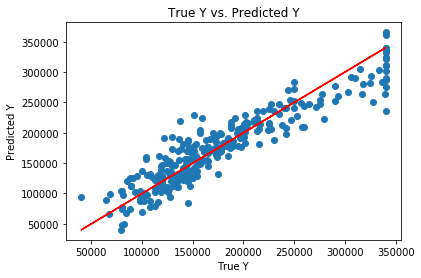

R2:  0.8195152077891262
RMSE: 25876.766640793398
MAE: 19706.862349291525
MAPE: 12.924601277030915
Alpha:  0.01


In [379]:
elastic = ElasticNet(alpha=.01)
elastic.fit(train_x, train_y)
pred_y = elastic.predict(test_x)

plt.scatter(test_y, pred_y)
plt.plot(test_y, test_y, color='red')
plt.title('True Y vs. Predicted Y')
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.show()

print('R2: ', elastic.score(train_x, train_y))
print('RMSE:', rmse(test_y, pred_y))
print('MAE:', mean_absolute_error(test_y, pred_y))
print('MAPE:', (np.abs(test_y - pred_y) / test_y).mean() *100)
print('Alpha: ', elastic.alpha)

Bartlett test statistic value is 210.536 and p value is 1.05e-47
Levene test statistic value is 154.419 and p value is 1.3e-31


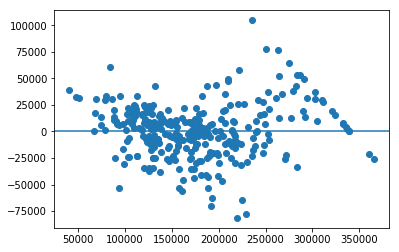

In [380]:
error_term = test_y - pred_y
plt.scatter(pred_y, error_term)
plt.axhline(y=0)


bart_stats = bartlett(pred_y, error_term)
lev_stats = levene(pred_y, error_term)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

# External Feature: Interest Rate

The dictionary below is the annual average 30-year fixed-rate mortgage according to the article [Historical Mortgage Rates](https://www.valuepenguin.com/mortgages/historical-mortgage-rates#nogo). We will match each observation's year sold column to the dictionary. 

In [381]:
avg_interest_rates = {2010: 4.69, 2009: 5.04, 2008: 6.03, 2007: 6.34, 2006: 6.41}

Since we are only focusing on residential real estate, we can drop the houses that aren't.

In [382]:
zoning = ['FV', 'C (all)']
original_df = list(original_df[~original_df.mszoning.isin(zoning)].index)

housing_df = housing_df[housing_df.index.isin(original_df)]

housing_df['interest_rate'] = housing_df.yrsold.apply(lambda x: avg_interest_rates[x])

In [383]:
feature_list = list(housing_df.loc[:,housing_df.columns != 'saleprice'].columns[1:])

train_x, test_x, train_y, test_y = train_test_split(
    housing_df[feature_list], housing_df['saleprice'], test_size=.2)

elastic = ElasticNet()
ridge = RidgeCV(alphas=(.01,1,10,100,1000))
lasso = Lasso()
linear = LinearRegression()
model_list = {'elastic': elastic, 'ridge': ridge, 'lasso': lasso, 'linear': linear}

model_df = model_results(model_list, train_x, train_y, test_x, test_y)

elastic


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

ridge
lasso


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

linear


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [384]:
model_df

,MAE,MAPE,best_alpha,coef,r2,root_MSE
model_name,,,,,,
elastic,1.532465e+04,9.530420,0.1,"[-89.83568516220718, -18.61988584334874, 1.277...",8.308553e-01,2.855868e+04
ridge,1.515449e+04,9.517438,10.0,"[-58.0, -43.0, 1.0, 7892.0, 6356.0, 265.0, 147...",8.324351e-01,2.842500e+04
lasso,1.500314e+04,9.360142,100.0,"[-62.66132890483842, -38.2718875849381, 1.3257...",8.329944e-01,2.837752e+04
linear,6.892019e+07,29305.391951,NaN,"[-21.0, -63.0, 1.0, 6889.0, 5539.0, 279.0, 163...",-1.708322e+08,9.075985e+08


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


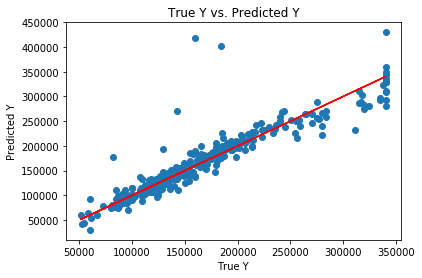

R2:  0.9451527259839793
RMSE: 28642.859646653575
MAE: 15273.405998461487
MAPE: 9.620882267153505
Alpha:  0.01


In [385]:
elastic = ElasticNet(alpha=.01)
elastic.fit(train_x, train_y)
pred_y = elastic.predict(test_x)

plt.scatter(test_y, pred_y)
plt.plot(test_y, test_y, color='red')
plt.title('True Y vs. Predicted Y')
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.show()

print('R2: ', elastic.score(train_x, train_y))
print('RMSE:', rmse(test_y, pred_y))
print('MAE:', mean_absolute_error(test_y, pred_y))
print('MAPE:', (np.abs(test_y - pred_y) / test_y).mean() *100)
print('Alpha: ', elastic.alpha)

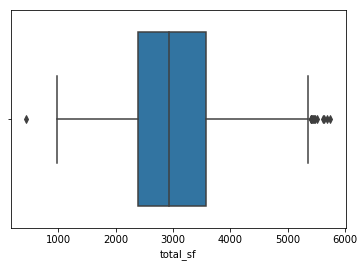

In [386]:
sns.boxplot(housing_df.total_sf)

In [387]:
housing_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,is_Pave,alley_Grvl,alley_None,alley_Pave,lotshape_IR1,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_Bnk,landcontour_HLS,landcontour_Low,landcontour_Lvl,is_AllPub,lotconfig_Corner,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_Gtl,landslope_Mod,landslope_Sev,neighborhood_Blmngtn,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,...,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj1,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,fireplacequ_Ex,fireplacequ_Fa,fireplacequ_Gd,fireplacequ_None,fireplacequ_Po,fireplacequ_TA,garagetype_2Types,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_None,garagefinish_Fin,garagefinish_None,garagefinish_RFn,garagefinish_Unf,garagequal_Ex,garagequal_Fa,garagequal_Gd,garagequal_None,garagequal_Po,garagequal_TA,garagecond_Ex,garagecond_Fa,garagecond_Gd,garagecond_None,garagecond_Po,garagecond_TA,paveddrive_N,paveddrive_P,paveddrive_Y,poolqc_Ex,poolqc_Fa,poolqc_Gd,poolqc_None,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,fence_None,miscfeature_Gar2,miscfeature_None,miscfeature_Othr,miscfeature_Shed,miscfeature_TenC,saletype_COD,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,total_sf,total_fullbaths,total_halfbaths,interest_rate
count,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.0,1385.000000,1385.000000,1385.000000,1385.000000,1385.0,1385.000000,1385.000000,1385.0,1385.000000,1385.000000,1385.000000,1385.0,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.0,1385.000000,1385.0,1385.0,1385.0,1385.000000,1385.000000,1385.000000,1385.0,1385.0,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,...,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000
mean,732.506137,52.245487,69.859567,9789.767509,6.064982,5.549458,1970.081588,1984.121300,90.07

In [388]:
test_x[pred_y > 500000]

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,is_Pave,alley_Grvl,alley_None,alley_Pave,lotshape_IR1,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_Bnk,landcontour_HLS,landcontour_Low,landcontour_Lvl,is_AllPub,lotconfig_Corner,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_Gtl,landslope_Mod,landslope_Sev,neighborhood_Blmngtn,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,...,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj1,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,fireplacequ_Ex,fireplacequ_Fa,fireplacequ_Gd,fireplacequ_None,fireplacequ_Po,fireplacequ_TA,garagetype_2Types,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_None,garagefinish_Fin,garagefinish_None,garagefinish_RFn,garagefinish_Unf,garagequal_Ex,garagequal_Fa,garagequal_Gd,garagequal_None,garagequal_Po,garagequal_TA,garagecond_Ex,garagecond_Fa,garagecond_Gd,garagecond_None,garagecond_Po,garagecond_TA,paveddrive_N,paveddrive_P,paveddrive_Y,poolqc_Ex,poolqc_Fa,poolqc_Gd,poolqc_None,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,fence_None,miscfeature_Gar2,miscfeature_None,miscfeature_Othr,miscfeature_Shed,miscfeature_TenC,saletype_COD,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,total_sf,total_fullbaths,total_halfbaths,interest_rate
